In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
Train = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train",
                                         image_size=(224, 224))
Valid = image_dataset_from_directory(directory="../input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid",
                                        image_size=(224, 224))

rescale = Rescaling(scale=1.0/255)
Train = Train.map(lambda image,label:(rescale(image),label))
Valid  = Valid.map(lambda image,label:(rescale(image),label))

Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [4]:
def get_model():
    mobilenet_base_model = keras.applications.MobileNet(weights="imagenet",
                                          input_shape=(224,224,3),
                                          include_top=False,)
    mobilenet_base_model.trainable = False
    #mobilenet_base_model.summary()
    inputs = keras.Input(shape=(224, 224, 3))
    x = mobilenet_base_model(inputs, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  
    outputs = keras.layers.Dense((38),activation="softmax")(x)

    mobilenet_model = keras.Model(inputs, outputs, name='model_mobilenet')
    mobilenet_model.summary()
    return mobilenet_model

In [5]:
history=[]
from keras import backend as K
ep = 5

model_Adam_Mobilenet=get_model()
opt1 = keras.optimizers.Adam(learning_rate=0.0001)
model_Adam_Mobilenet.compile(optimizer=opt1,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
history.append(model_Adam_Mobilenet.fit(Train,
          validation_data=Valid,
          epochs = ep))
model_Adam_Mobilenet.save('model_Adam_Mobilenet.h5')
K.clear_session()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 38)                38950     
                                                    

In [6]:
model_RMSprop_Mobilenet=get_model()
opt2 = keras.optimizers.RMSprop(learning_rate=0.0001)
model_RMSprop_Mobilenet.compile(optimizer=opt2,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
history.append(model_RMSprop_Mobilenet.fit_generator(Train,
          validation_data=Valid,
          epochs = ep))
model_RMSprop_Mobilenet.save('model_Adam_Mobilenet.h5')
K.clear_session()

Model: "model_mobilenet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 38)                38950     
                                                                 
Total params: 3,267,814
Trainable params: 38,950
No

/tmp/ipykernel_32/1765910963.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history.append(model_RMSprop_Mobilenet.fit_generator(Train,


2197/2197 [==============================] - 79s 35ms/step - loss: 1.1975 - accuracy: 0.6896 - val_loss: 0.4004 - val_accuracy: 0.9006
Epoch 2/5
2197/2197 [==============================] - 77s 35ms/step - loss: 0.3466 - accuracy: 0.9017 - val_loss: 0.2515 - val_accuracy: 0.9288
Epoch 3/5
2197/2197 [==============================] - 77s 35ms/step - loss: 0.2484 - accuracy: 0.9262 - val_loss: 0.1998 - val_accuracy: 0.9413
Epoch 4/5
2197/2197 [==============================] - 77s 35ms/step - loss: 0.2048 - accuracy: 0.9380 - val_loss: 0.1737 - val_accuracy: 0.9473
Epoch 5/5
2197/2197 [==============================] - 77s 35ms/step - loss: 0.1800 - accuracy: 0.9440 - val_loss: 0.1558 - val_accuracy: 0.9519


Adam



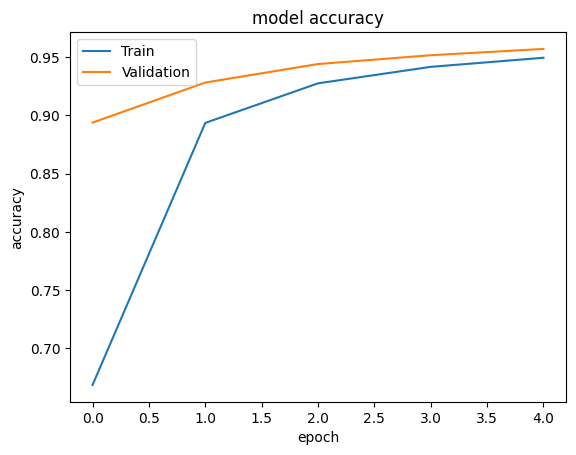

RMSProp



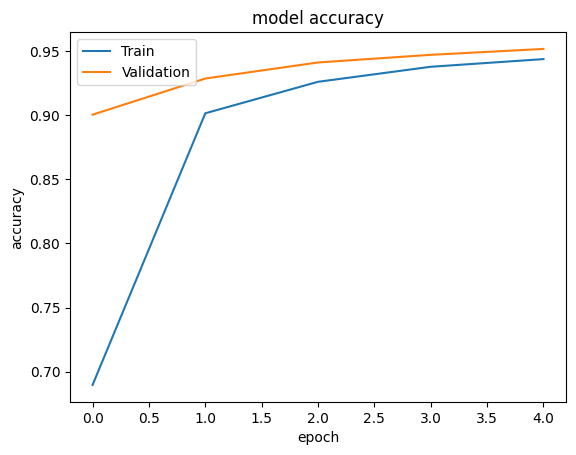

In [8]:
import matplotlib.pyplot as plt
optimizer=["Adam","RMSProp"]

for i in range(len(history)):
    print(optimizer[i])
    print()
    plt.plot(history[i].history['accuracy'])
    plt.plot(history[i].history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

Adam



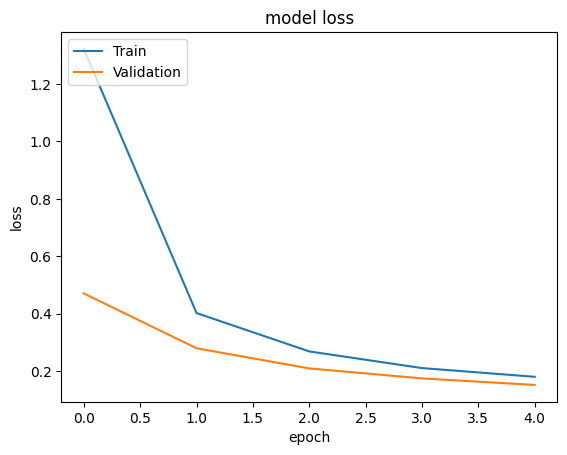

RMSProp



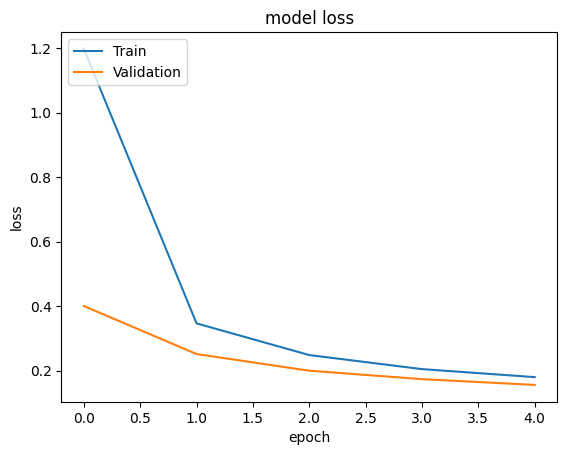

In [9]:
for i in range(len(history)):
    print(optimizer[i])
    print()
    plt.plot(history[i].history['loss'])
    plt.plot(history[i].history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

1/1 [==============================] - 0s 21ms/step


<Figure size 2000x500 with 0 Axes>

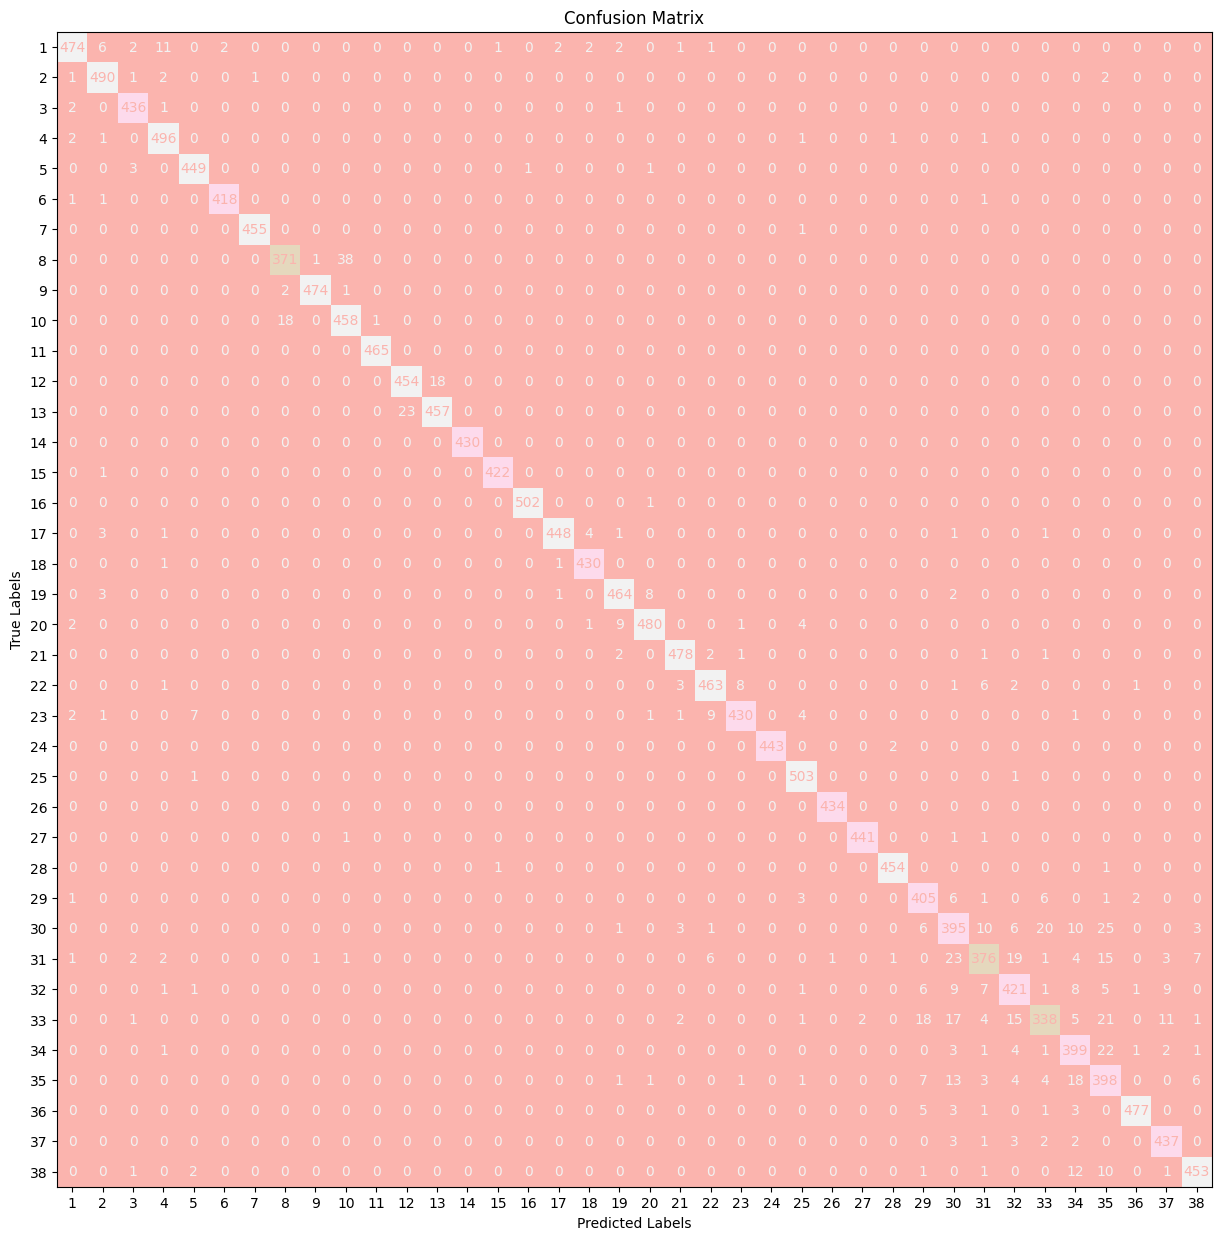

In [12]:
labels = []
predictions = []
precision = []
recall = []
test_accuracy = []
import itertools

for x,y in Valid:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model_Adam_Mobilenet.predict(x),1).numpy())

predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
test_accuracy.append(accuracy_score(labels, predictions) * 100)
precision.append(precision_score(labels, predictions, average='micro') * 100)
recall.append(recall_score(labels, predictions, average='micro') * 100)

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'Pastel1')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 414ms/step


<Figure size 2000x500 with 0 Axes>

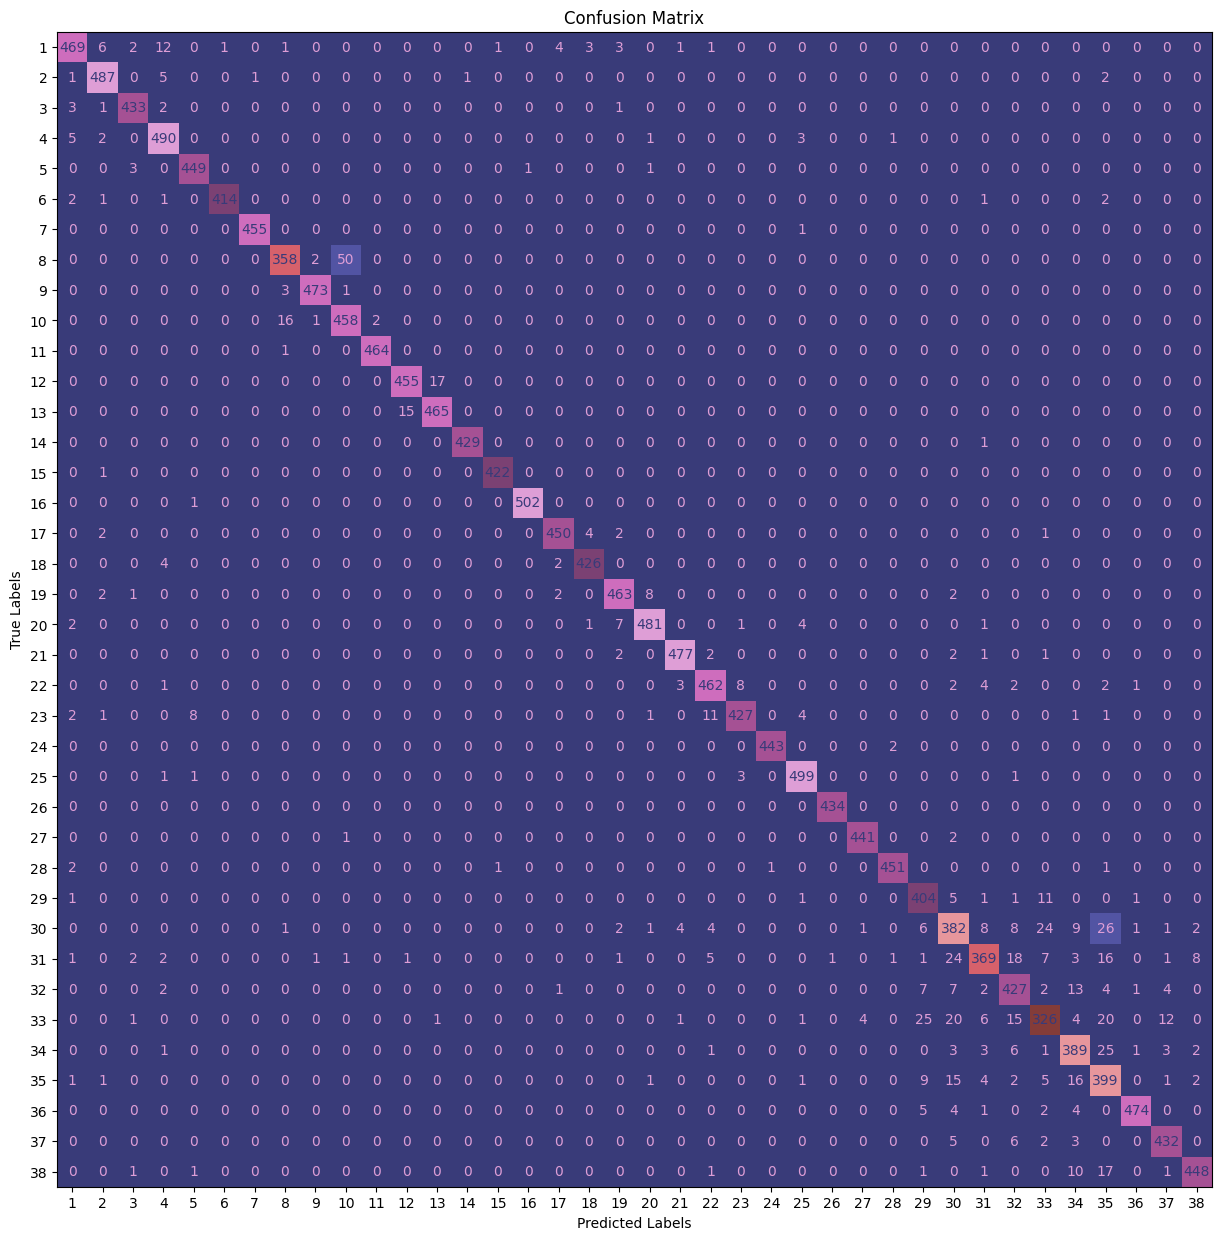

In [14]:
labels = []
predictions = []


for x,y in Valid:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model_RMSprop_Mobilenet.predict(x),1).numpy())

predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))
test_accuracy.append(accuracy_score(labels, predictions) * 100)
precision.append(precision_score(labels, predictions, average='micro') * 100)
recall.append(recall_score(labels, predictions, average='micro') * 100)

plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'tab20b')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()